# Zarr Cloud native format in Earth Observation Application Packages

## Part 1 - Application Package execution

Use `cwltool` to run the Application Package

### Modules used

In [1]:
import yaml
from shutil import which
import nest_asyncio
from cwltool.main import main
from io import StringIO
import argparse
import json
nest_asyncio.apply()

### Container runtime

Check if `podman` or `docker` are available:

In [2]:
if which("podman"):
    podman = True
    print("Using podman")
elif which("docker"):
    podman = False
    print("Using docker")
else:
    raise ValueError("No container engine")

podman = False

Using podman


### Prepare the Application Package execution

Use `cwltool` and Python to execute the Application Package.



In [3]:
params = {}

params["bands"] = ["green", "nir"]

params["stac_api_endpoint"] = {
    "url": {"value": "https://earth-search.aws.element84.com/v1/"},
    "headers": [],
}

params["search_request"] = {
    "limit": 20,
    "collections": ["sentinel-2-l2a"],
    "datetime_interval": {
        "start": {"value": "2021-06-01T00:00:00"},
        "end": {"value": "2021-08-01T23:59:59"},
    },
    "bbox": [-121.399, 39.834, -120.74, 40.472],
    "max-items": 10
}

with open("params.yaml", "w") as file:
    print(yaml.dump(params), file=file)

### Application Package execution

We use the released application package available here: https://github.com/eoap/zarr-cloud-native-format/releases

In [4]:

parsed_args = argparse.Namespace(
    podman=podman,
    parallel=False,
    validate=False,
    debug=False,
    outdir="./runs",
    quiet=True,
    workflow="https://github.com/eoap/zarr-cloud-native-format/releases/download/0.3.0/app-water-bodies.0.3.0.cwl#water-bodies",
    job_order=["params.yaml"],
)

stream_out = StringIO()
stream_err = StringIO()

res = main(
    args=parsed_args,
    stdout=stream_out,
    stderr=stream_err,
)

assert res == 0

Error: No such object: ghcr.io/eoap/zarr-cloud-native-format/stac-zarr@sha256:c667be193e01f9cb06ffa0ab13edf4dfdf893332cfc8e3709f0396d751a9b351


The `stream_out` object contains the cwltool stdout.

We can list the results keys with:

In [29]:
results = json.loads(stream_out.getvalue())

list(results.keys())

['zarr_stac_catalog', 'stac_catalog']

And find the location of the directory containing the STAC Catalog:

In [30]:
results["zarr_stac_catalog"]["location"]

'file:///data/work/github/eoap/zarr-cloud-native-format/docs/runs/ekic17nn'

## Part 2 - Inspect Application Package results

Read the STAC Catalog containing the zarr result

### Modules

In [31]:
import pystac
import os
from pystac.extensions.datacube import DatacubeExtension


### Inpect the STAC Item metadata

In [32]:
cat = pystac.Catalog.from_file(
    os.path.join(
        results["zarr_stac_catalog"]["location"].replace("file://", ""), "catalog.json"
    )
)

In [33]:
cat.describe()

* <Catalog id=water-bodies>
    * <Collection id=water-bodies>


In [34]:
collection = cat.get_child("water-bodies")

collection.describe()

* <Collection id=water-bodies>


In [35]:
collection.to_dict()

{'type': 'Collection',
 'id': 'water-bodies',
 'stac_version': '1.1.0',
 'description': 'Collection of detected water bodies',
 'links': [{'rel': 'root',
   'href': '../catalog.json',
   'type': 'application/json',
   'title': 'Water bodies catalog'},
  {'rel': 'self',
   'href': '/data/work/github/eoap/zarr-cloud-native-format/docs/runs/ekic17nn/water-bodies/collection.json',
   'type': 'application/json'},
  {'rel': 'parent',
   'href': '../catalog.json',
   'type': 'application/json',
   'title': 'Water bodies catalog'}],
 'stac_extensions': ['https://stac-extensions.github.io/datacube/v2.2.0/schema.json'],
 'cube:dimensions': {'x': {'type': 'spatial',
   'axis': 'x',
   'extent': [636995.0, 691585.0],
   'reference_system': '32610',
   'description': 'X coordinate of projection'},
  'y': {'type': 'spatial',
   'axis': 'y',
   'extent': [4410555.0, 4482595.0],
   'reference_system': '32610',
   'description': 'Y coordinate of projection'},
  'time': {'type': 'temporal',
   'extent':

In [36]:
zarr_asset = collection.get_assets()["data"]

zarr_asset

<Asset href=result.zarr>

Inspect the datacube extension metadata:

In [37]:
dc_collection = DatacubeExtension.ext(collection)

* List and describe the dimensions

In [38]:
dc_collection.dimensions

{'x': <pystac.extensions.datacube.HorizontalSpatialDimension at 0x77b70a6d0410>,
 'y': <pystac.extensions.datacube.HorizontalSpatialDimension at 0x77b70a6d18b0>,
 'time': <pystac.extensions.datacube.TemporalDimension at 0x77b70a3d6210>}

In [39]:
for key, value in dc_collection.dimensions.items():

    print(key, dc_collection.dimensions[key].to_dict())

x {'type': 'spatial', 'axis': 'x', 'extent': [636995.0, 691585.0], 'reference_system': '32610', 'description': 'X coordinate of projection'}
y {'type': 'spatial', 'axis': 'y', 'extent': [4410555.0, 4482595.0], 'reference_system': '32610', 'description': 'Y coordinate of projection'}
time {'type': 'temporal', 'extent': ['2021-06-28T19:03:24.330000000', '2021-07-28T19:03:25.963000000'], 'description': 'Time dimension'}


* List and describe the variables

In [40]:
dc_collection.variables

{'data': <pystac.extensions.datacube.Variable at 0x77b70a6ef490>}

In [41]:
for key, value in dc_collection.variables.items():
    print(key, dc_collection.variables[key].to_dict())

data {'type': 'bands', 'name': 'data', 'description': 'detected water bodies', 'dimensions': ['y', 'x', 'time'], 'chunks': [512, 512, 1]}


In [42]:
dc_collection.variables["data"].to_dict()

{'type': 'bands',
 'name': 'data',
 'description': 'detected water bodies',
 'dimensions': ['y', 'x', 'time'],
 'chunks': [512, 512, 1]}

## Part 3 - Inspect the zarr result

Open the Zarr result

### Modules

In [43]:
import xarray as xr

In [44]:
zarr_asset.extra_fields["xarray:open_kwargs"]

{'consolidated': True}

### Open the Zarr result with xarray

In [45]:
water_bodies = xr.open_zarr(zarr_asset.get_absolute_href(), **zarr_asset.extra_fields["xarray:open_kwargs"])


In [46]:
xr.set_options(display_style="text")

water_bodies

<xarray.Dataset> Size: 315MB
Dimensions:      (time: 8, y: 7205, x: 5460)
Coordinates:
  * time         (time) datetime64[ns] 64B 2021-06-28T19:03:24.330000 ... 202...
  * x            (x) float64 44kB 6.37e+05 6.37e+05 ... 6.916e+05 6.916e+05
  * y            (y) float64 58kB 4.483e+06 4.483e+06 ... 4.411e+06 4.411e+06
Data variables:
    data         (time, y, x) uint8 315MB dask.array<chunksize=(1, 512, 512), meta=np.ndarray>
    spatial_ref  int32 4B ...

* Check the geospatial metadata

In [47]:
water_bodies.data_vars["spatial_ref"]

<xarray.DataArray 'spatial_ref' ()> Size: 4B
[1 values with dtype=int32]
Attributes: (12/18)
    GeoTransform:                      636990 10 0 4482600 0 -10
    crs_wkt:                           PROJCRS["WGS 84 / UTM zone 10N",BASEGE...
    false_easting:                     500000.0
    false_northing:                    0.0
    geographic_crs_name:               WGS 84
    grid_mapping_name:                 transverse_mercator
    ...                                ...
    projected_crs_name:                WGS 84 / UTM zone 10N
    reference_ellipsoid_name:          WGS 84
    scale_factor_at_central_meridian:  0.9996
    semi_major_axis:                   6378137.0
    semi_minor_axis:                   6356752.314245179
    spatial_ref:                       PROJCRS["WGS 84 / UTM zone 10N",BASEGE...

In [48]:
str(water_bodies.data_vars["spatial_ref"].values)

'32610'

* Inspect the Zarr coordinates

In [49]:
water_bodies.coords

Coordinates:
  * time     (time) datetime64[ns] 64B 2021-06-28T19:03:24.330000 ... 2021-07...
  * x        (x) float64 44kB 6.37e+05 6.37e+05 6.37e+05 ... 6.916e+05 6.916e+05
  * y        (y) float64 58kB 4.483e+06 4.483e+06 ... 4.411e+06 4.411e+06

* List the values of the `time` coordinate:

In [50]:
water_bodies.coords["time"].values

array(['2021-06-28T19:03:24.330000000', '2021-07-08T19:03:25.409000000',
       '2021-07-08T19:03:25.410000000', '2021-07-13T19:03:24.627000000',
       '2021-07-18T19:03:25.940000000', '2021-07-23T19:03:24.661000000',
       '2021-07-28T19:03:25.962000000', '2021-07-28T19:03:25.963000000'],
      dtype='datetime64[ns]')

* Plot the water bodies detected on '2021-07-13T19:03:24.000000000'

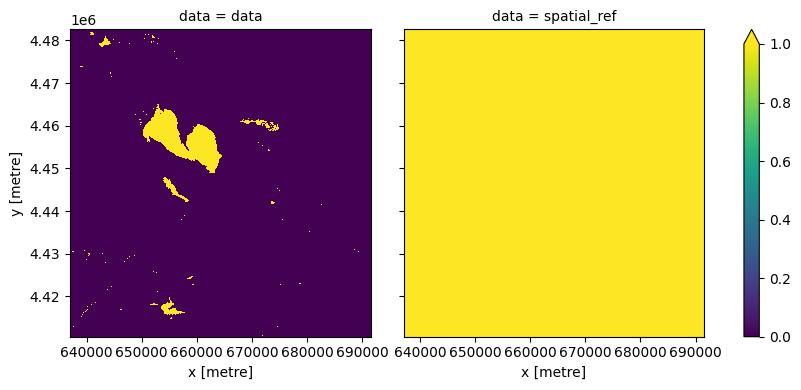

In [51]:
_ = (
    water_bodies.isel(time=1)
    .to_array("data")
    .plot.imshow(
        col="data",
        size=4,
        vmin=0,
        vmax=1,
    )
)